100%|██████████| 5/5 [01:05<00:00, 13.10s/it]


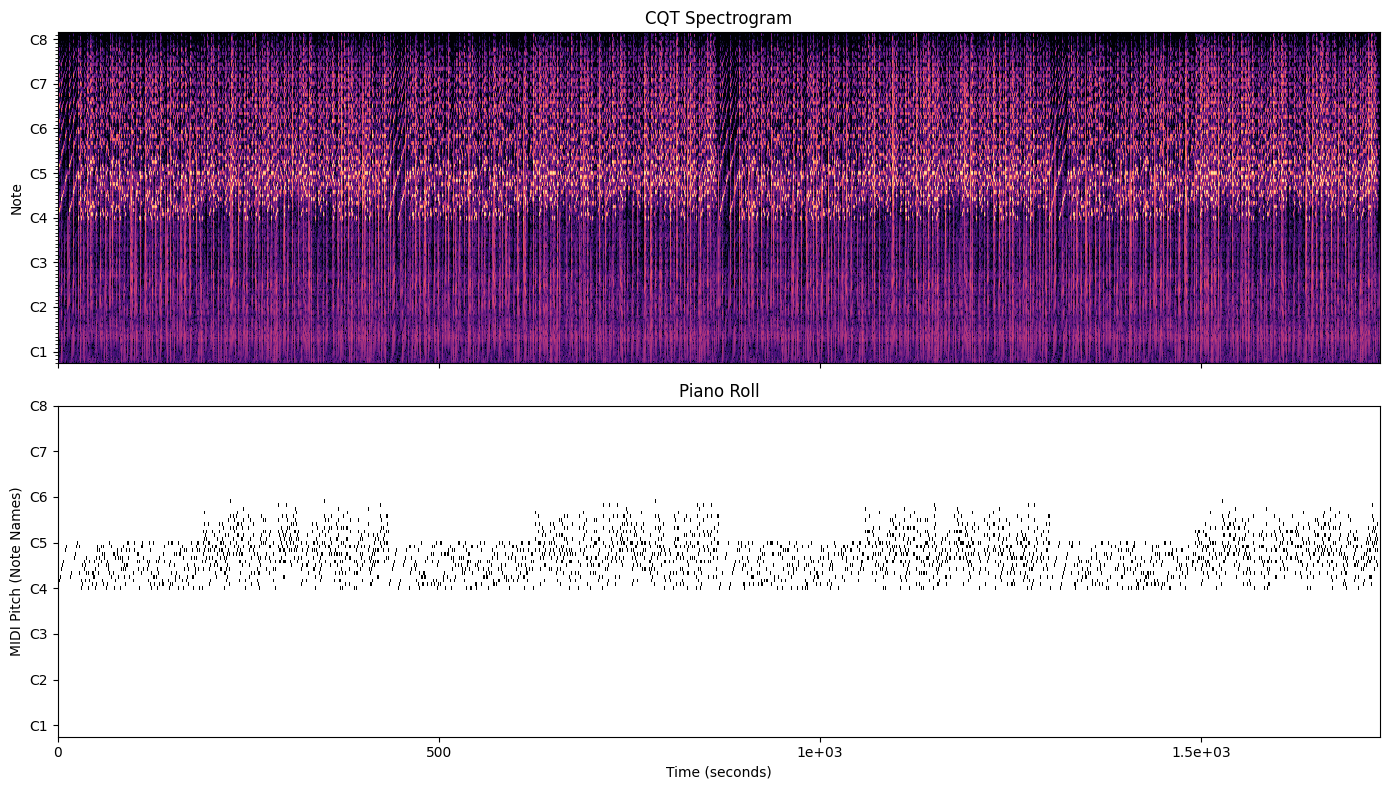

Sliding Window Output Shape: (173904, 267, 9, 1)
Sliding Window MIDI Output Shape: (173904, 128, 9)


c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 252, 8, 10)     │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 126, 8, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 116, 6, 20)     │         6,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 58, 6, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     1,782,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821,862 (6.95 MB)

 Trainable params: 1,821,862 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.2547 - loss: 0.4145 - val_accuracy: 0.3897 - val_loss: 0.0062
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.3794 - loss: 0.0100 - val_accuracy: 0.3308 - val_loss: 0.0042
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.3730 - loss: 0.0072 - val_accuracy: 0.3617 - val_loss: 0.0030
Epoch 4/50
 89/544 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.3604 - loss: 0.0061

KeyboardInterrupt: 

In [ ]:
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import os
from tqdm import tqdm

# CQT Configuration 
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

def plot_cqt_with_pianoroll(audio_path, midi_path):
    cqt_list = []
    y, _ = librosa.load(audio_path, sr=sr)

    C = librosa.cqt(
        y, sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave
    )
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    # Load MIDI and get piano roll
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    fs_pianoroll = sr / hop_length  # Frame rate to match CQT
    piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

    # Align time axes
    n_frames = min(C_dB.shape[1], piano_roll.shape[1])
    C_dB = C_dB[:, :n_frames]
    piano_roll = piano_roll[:, :n_frames]
    cqt_list.append(C_dB)
    return C_dB, piano_roll


audio_path = 'dataset'
# midi_path = 'full'

num_sample =5
cqt_list = []
piano_list = []

for i in tqdm(range(0,num_sample)):
    if i:
    #     audio = os.path.join(audio_path, f'all-harmonic-intervals-{i}.mp3')
    #     midi = os.path.join(midi_path, f'all_harmonic_intervals_{i}.mid')
        audio = os.path.join(audio_path, 'combined_dataset.mp3')
        midi = os.path.join(audio_path, 'combined_dataset.mid')

        cqt , piano = plot_cqt_with_pianoroll(audio, midi)
        cqt_list.append(cqt)
        piano_list.append(piano)
cqt_concat = np.concatenate(cqt_list, axis=1)  # along time axis
piano_concat = np.concatenate(piano_list, axis=1)

duration_sec = piano_concat.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

num_plot = 10000
# Plot CQT 
librosa.display.specshow(
    cqt_concat[:,:],
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  

# Plot Piano Roll
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_concat[pitch_min:pitch_max+1, :],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()





def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis] 

def create_sliding_windows_midi(midi, window_size=9, stride=1):
    pad = window_size // 2
    midi_padded = np.pad(midi, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
    num_time_bins = midi.shape[1]

    windows = np.array([
        midi_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows, len(windows)


X_input = create_sliding_windows(cqt_concat, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window Output Shape:", X_input.shape)

Y_output, num_windows_midi = create_sliding_windows_midi(piano_concat, window_size=9, stride=1)
print("Sliding Window MIDI Output Shape:", Y_output.shape)
Y_output_flattened = np.max(Y_output, axis=2) > 90  # Shape: (n, 128)


import tensorflow as tf
num_classes = 128
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(267, 9, 1), name="conv1"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool1"),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid', name="conv2"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool2"),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu', name="fc1"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="fc2")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_input, Y_output_flattened, 
          epochs=50, 
          batch_size=256,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
          )
model.save("poly_50.h5")

Sliding Window Output Shape: (173904, 267, 9, 1)
Sliding Window MIDI Output Shape: (173904, 128, 9)


In [ ]:

# print("Xtrain : ",X_input.shape)
# print("out : ",Y_output.shape)
# print("Ytrain : ",Y_output_flattened.shape)

Xtrain :  (173904, 267, 9, 1)
out :  (173904, 128, 9)
Ytrain :  (173904, 128)


In [81]:
# librosa.display.specshow(cqt_concat[:, :100], sr=sr, hop_length=hop_length,
#                             x_axis='time', y_axis='cqt_note',
#                             fmin=fmin, bins_per_octave=bins_per_octave,
#                             cmap='magma')


c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 252, 8, 10)     │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 126, 8, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 116, 6, 20)     │         6,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 58, 6, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     1,782,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821,862 (6.95 MB)

 Trainable params: 1,821,862 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
import tensorflow as tf
num_classes = 128
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(267, 9, 1), name="conv1"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool1"),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid', name="conv2"),
    tf.keras.layers.MaxPooling2D((2, 1), name="pool2"),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu', name="fc1"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="fc2")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_input, Y_output_flattened, 
          epochs=50, 
          batch_size=256,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
          )
model.save("poly_50.h5")

Epoch 1/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.3608 - loss: 0.0016 - val_accuracy: 0.2916 - val_loss: 3.3359e-04
Epoch 2/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.3702 - loss: 0.0011 - val_accuracy: 0.3323 - val_loss: 2.6702e-04
Epoch 3/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 33s 61ms/step - accuracy: 0.3723 - loss: 9.4069e-04 - val_accuracy: 0.3024 - val_loss: 1.6296e-04
Epoch 4/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.3785 - loss: 8.4333e-04 - val_accuracy: 0.2926 - val_loss: 1.3630e-04
Epoch 5/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 56ms/step - accuracy: 0.3861 - loss: 7.5560e-04 - val_accuracy: 0.3572 - val_loss: 1.1436e-04
Epoch 6/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - accuracy: 0.4112 - loss: 7.5213e-04 - val_accuracy: 0.3141 - val_loss: 1.1855e-04
Epoch 7/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.4049 - loss: 6.6445e-04 - val_accuracy: 0.3147 - val_loss: 2.4694e-04
Epoch 8/50
544/544 ━━━━━━━━━━━━━━━━━━━━ 31

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import pretty_midi
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import datetime

# --- Configuration ---
SR = 22050
HOP_LENGTH_SEC = 0.01
HOP_LENGTH = int(HOP_LENGTH_SEC * SR)
FMIN = librosa.note_to_hz('A0')
BINS_PER_OCTAVE = 36
N_BINS = 267
NUM_CLASSES = 128
WINDOW_SIZE = 9
STRIDE = 1

# Training 
EPOCH = 1
BATCH_SIZE = 256
LEARNING_RATE = 0.0001

# --- Paths ---
AUDIO_DIR = 'dataset'
AUDIO_FILE = 'combined_dataset.mp3'
MIDI_FILE = 'combined_dataset.mid'
NUM_SAMPLES = 1


# --- Utility Functions ---
def compute_cqt(audio_path):
    y, _ = librosa.load(audio_path, sr=SR)
    C = librosa.cqt(
        y, sr=SR, hop_length=HOP_LENGTH, fmin=FMIN,
        n_bins=N_BINS, bins_per_octave=BINS_PER_OCTAVE
    )
    return librosa.amplitude_to_db(np.abs(C), ref=np.max)


def compute_pianoroll(midi_path):
    midi = pretty_midi.PrettyMIDI(midi_path)
    fs = SR / HOP_LENGTH
    return midi.get_piano_roll(fs=fs)


# def plot_cqt_and_pianoroll(cqt, piano_roll):
#     duration_sec = piano_roll.shape[1] * HOP_LENGTH / SR
#     fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

#     # Plot CQT
#     librosa.display.specshow(
#         cqt, sr=SR, hop_length=HOP_LENGTH, x_axis='s',
#         y_axis='cqt_note', fmin=FMIN, bins_per_octave=BINS_PER_OCTAVE,
#         cmap='magma', ax=axs[0]
#     )
#     axs[0].set_title("CQT Spectrogram")
#     axs[0].label_outer()

#     # Plot piano roll
#     pitch_min, pitch_max = 21, 108
#     axs[1].imshow(
#         piano_roll[pitch_min:pitch_max + 1, :],
#         aspect='auto', origin='lower', cmap='gray_r',
#         interpolation='nearest', extent=[0, duration_sec, pitch_min, pitch_max]
#     )
#     axs[1].set_xlabel('Time (s)')
#     axs[1].set_ylabel('MIDI Pitch')
#     axs[1].set_title('Piano Roll')
#     axs[1].set_ylim(pitch_min, pitch_max)

#     c_notes = [n for n in range(pitch_min, pitch_max + 1)
#                if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
#     axs[1].set_yticks(c_notes)
#     axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

#     plt.tight_layout()
#     plt.show()


def create_sliding_windows(data, window_size=9, stride=1, pad_mode='edge', constant_value=0):
    pad = window_size // 2
    pad_width = ((0, 0), (pad, pad))

    if pad_mode == 'constant':
        padded_data = np.pad(data, pad_width, mode='constant', constant_values=constant_value)
    else:
        padded_data = np.pad(data, pad_width, mode=pad_mode)

    windows = np.array([
        padded_data[:, i:i + window_size]
        for i in range(0, data.shape[1], stride)
    ])
    
    return windows[..., np.newaxis]



def create_binary_labels(midi_windows, threshold=90):
    return (np.max(midi_windows, axis=2) > threshold).astype(np.float32)


# --- Data Preparation ---
cqt_list, piano_list = [], []

for i in tqdm(range(NUM_SAMPLES)):
    audio_path = os.path.join(AUDIO_DIR, AUDIO_FILE)
    midi_path = os.path.join(AUDIO_DIR, MIDI_FILE)

    cqt = compute_cqt(audio_path)
    piano = compute_pianoroll(midi_path)

    # Align time steps
    min_frames = min(cqt.shape[1], piano.shape[1])
    cqt_list.append(cqt[:, :min_frames])
    piano_list.append(piano[:, :min_frames])

# Concatenate all samples
cqt_concat = np.concatenate(cqt_list, axis=1)
piano_concat = np.concatenate(piano_list, axis=1)

# Optional: plot
# plot_cqt_and_pianoroll(cqt_concat, piano_concat)

# Create sliding windows
X_input = create_sliding_windows(cqt_concat, WINDOW_SIZE, STRIDE)
Y_windows = create_sliding_windows(piano_concat, WINDOW_SIZE, STRIDE, pad_mode='constant', constant_value=0)
Y_output = create_binary_labels(Y_windows)

print("Input shape :", X_input.shape)   # e.g., (n, 267, 9, 1)
print("Output shape:", Y_output.shape)  # e.g., (n, 128)

# --- Model Training ---
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(N_BINS, WINDOW_SIZE, 1)),
    tf.keras.layers.MaxPooling2D((2, 1)),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D((2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

model.fit(
    X_input, Y_output,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[tensorboard_callback]
)

model.save("poly_.h5")


100%|██████████| 1/1 [00:40<00:00, 40.59s/it]


Input shape : (43476, 267, 9, 1)
Output shape: (43476, 128, 1)


c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 252, 8, 10)     │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 126, 8, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 116, 6, 20)     │         6,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 6, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,782,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821,862 (6.95 MB)

 Trainable params: 1,821,862 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

OverflowError: Python int too large to convert to C long